# Credit Risk Resampling Techniques

In [28]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

# Read the CSV and Perform Basic Data Cleaning

In [30]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [31]:
# Load the data
file_path = Path('resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


# Split the Data into Training and Testing

In [32]:
from sklearn.model_selection import train_test_split
# Create our features
X = df.drop("loan_status", axis=1)
X = pd.get_dummies(X)

# Create our target
y = df[['loan_status']]

In [33]:
X.describe()


,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [34]:
# Check the balance of our target values
y['loan_status'].value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print("Training:",Counter(y_train['loan_status']))
print("Test:",Counter(y_test['loan_status']))

Training: Counter({'low_risk': 51366, 'high_risk': 246})
Test: Counter({'low_risk': 17104, 'high_risk': 101})


# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [36]:
# Resample the training data with the RandomOversampler
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(sampling_strategy='minority')
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(Counter(y_resampled['loan_status']))

Counter({'low_risk': 51366, 'high_risk': 51366})


In [37]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=1)
classifier

LogisticRegression(random_state=1)

In [38]:
# Calculated the balanced accuracy score
from sklearn.metrics import confusion_matrix, classification_report,balanced_accuracy_score
classifier.fit(X_resampled, y_resampled)
y_pred = classifier.predict(X_test)
balanced_accuracy_score(y_test,y_pred)

0.6637703877964971

In [41]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
cm_df = pd.DataFrame(
    cm, index=["Actual high risk", "Actual low risk"], columns=["Predicted high risk", "Predicted low risk"])

cm_df

[[   70    31]
 [ 6252 10852]]


,Predicted high risk,Predicted low risk
Actual high risk,70,31
Actual low risk,6252,10852


In [42]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.69      0.63      0.02      0.66      0.44       101
   low_risk       1.00      0.63      0.69      0.78      0.66      0.44     17104

avg / total       0.99      0.63      0.69      0.77      0.66      0.44     17205



### SMOTE Oversampling

In [43]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE
over = SMOTE(random_state = 101, sampling_strategy='auto')
X_oversampled, y_oversampled = over.fit_resample(X_train, y_train)
print(Counter(y_oversampled['loan_status']))

Counter({'low_risk': 51366, 'high_risk': 51366})


In [44]:
# Train the Logistic Regression model using the resampled data
smote_classifier = LogisticRegression(random_state=1)
smote_classifier

LogisticRegression(random_state=1)

In [46]:
# Calculated the balanced accuracy score
smote_classifier.fit(X_oversampled, y_oversampled)
y_pred_smote = smote_classifier.predict(X_test)
balanced_accuracy_score(y_test,y_pred_smote)

0.652123236762404

In [47]:
# Display the confusion matrix
cm_smote = confusion_matrix(y_test, y_pred_smote)
print(cm_smote)
cm_df_smote = pd.DataFrame(
    cm_smote, index=["Actual high risk", "Actual low risk"], columns=["Predicted high risk", "Predicted low risk"])

cm_df_smote

[[   63    38]
 [ 5465 11639]]


,Predicted high risk,Predicted low risk
Actual high risk,63,38
Actual low risk,5465,11639


In [48]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_smote))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.62      0.68      0.02      0.65      0.42       101
   low_risk       1.00      0.68      0.62      0.81      0.65      0.43     17104

avg / total       0.99      0.68      0.62      0.80      0.65      0.43     17205



# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [49]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.under_sampling import ClusterCentroids
under_sampler = ClusterCentroids(random_state = 42, sampling_strategy='auto')
X_undersampled, y_undersampled = under_sampler.fit_resample(X_train, y_train)
print(Counter(y_undersampled['loan_status']))

Counter({'high_risk': 246, 'low_risk': 246})


In [ ]:
# Train the Logistic Regression model using the resampled data
classifier_cluster_centroid = LogisticRegression(random_state=1)
classifier_cluster_centroid

LogisticRegression(random_state=1)

In [ ]:
# Calculated the balanced accuracy score
classifier_cluster_centroid.fit(X_undersampled, y_undersampled)
y_pred_undersample = classifier_cluster_centroid.predict(X_test)
balanced_accuracy_score(y_test,y_pred_undersample)

0.5473255054691625

In [ ]:
# Display the confusion matrix
cm_undersample = confusion_matrix(y_test, y_pred_undersample)
print(cm_undersample)
cm_df_undersample = pd.DataFrame(
    cm_undersample, index=["Actual high risk", "Actual low risk"], columns=["Predicted high risk", "Predicted low risk"])

cm_df_undersample

[[   69    32]
 [10066  7038]]


,Predicted high risk,Predicted low risk
Actual high risk,69,32
Actual low risk,10066,7038


In [ ]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_undersample))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.68      0.41      0.01      0.53      0.29       101
   low_risk       1.00      0.41      0.68      0.58      0.53      0.27     17104

avg / total       0.99      0.41      0.68      0.58      0.53      0.27     17205



# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [50]:
# Resample the training data with SMOTEENN
from imblearn.combine import SMOTEENN
combined = SMOTEENN(random_state = 42, sampling_strategy='all', smote=over) # smote object is over
X_combined, y_combined = combined.fit_resample(X_train, y_train)
print(Counter(y_combined['loan_status']))

Counter({'high_risk': 51358, 'low_risk': 46652})


In [51]:
# Train the Logistic Regression model using the resampled data
classifier_combined = LogisticRegression(random_state=1)
classifier_combined

LogisticRegression(random_state=1)

In [52]:
# Calculated the balanced accuracy score
classifier_combined.fit(X_combined, y_combined)
y_pred_combined = classifier_combined.predict(X_test)
balanced_accuracy_score(y_test,y_pred_combined)

0.6585782145801109

In [53]:
# Display the confusion matrix
cm_combined = confusion_matrix(y_test, y_pred_combined)
print(cm_combined)
cm_df_combined = pd.DataFrame(
    cm_combined, index=["Actual high risk", "Actual low risk"], columns=["Predicted high risk", "Predicted low risk"])

cm_df_combined

[[  74   27]
 [7107 9997]]


,Predicted high risk,Predicted low risk
Actual high risk,74,27
Actual low risk,7107,9997


In [54]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_combined))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.73      0.58      0.02      0.65      0.43       101
   low_risk       1.00      0.58      0.73      0.74      0.65      0.42     17104

avg / total       0.99      0.59      0.73      0.73      0.65      0.42     17205



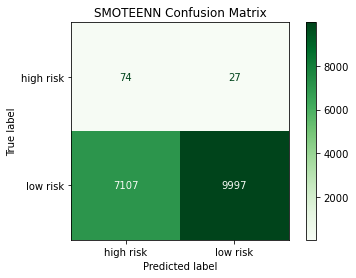

In [55]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
fig = plot_confusion_matrix(classifier_combined, X_test, y_test, display_labels=['high risk', 'low risk'], cmap='Greens')
plt.title('SMOTEENN Confusion Matrix')
plt.show()